In [2]:
import pandas as pd

from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator
import matplotlib.cm as cm
import matplotlib.colors as mcolors

import numpy as np
from scipy.special import erf
import h5py
import os
from unyt import angstrom, Msun, yr, m, erg, s, Hz

from synthesizer.grid import Grid
from synthesizer import Sed

import swiftascmaps
import cmasher as cmr


plt.rcParams['figure.dpi'] = 100
mpl.rcParams.update({'font.size': 14})

def get_n_colors_from_cmap(n, cmap_name="viridis"):
    cmap = plt.get_cmap(cmap_name)
    colors = [cmap(i) for i in np.linspace(0, 0.9, n)]
    return colors

In [16]:
subvolumes = ["0_0_0"]  # keep only the ones you want

pipeline_dir = '/mnt/home/snewman/ceph/pipeline_results/combined'
pipeline_name = 'pipeline_nodust_mdotcut_subradio'

wavelengths = np.logspace(0.1, 6, 100000) * angstrom

def get_lf(pipeline_name):

    # From the .hdf5 get the spectra

    FUV_slope = np.concatenate([
        h5py.File(os.path.join(pipeline_dir, f'{pipeline_name}.hdf5'), 'r')['Galaxies/LHC_FUV_slope'][:]
        for subvol in subvolumes
    ])

    print('FUV slope:', FUV_slope)

    grp_total = 'Galaxies/Spectra/SpectralLuminosityDensities/total'
    spectra = np.concatenate([
        h5py.File(os.path.join(pipeline_dir, f'{pipeline_name}.hdf5'), 'r')[f'{grp_total}'][:]
        for subvol in subvolumes
    ])
    print(f'Gathered spectra for {pipeline_name} and {spectra.shape} galaxies')

    print(spectra[0])

    """

    # And get the B band luminosity for each galaxy

    sed = Sed(wavelengths, spectra * erg / (s * Hz))
    B_band_window_limits = (3646 * angstrom, 6936 * angstrom)
    B_lum = sed.measure_window_luminosity(B_band_window_limits)
    log_B = np.log10(B_lum)

    print(f'Calculated B luminosities for {pipeline_name} and {spectra.shape} galaxies')

    # Define the volume for CAMELS-SAM

    BOX_SIZE = 150.0 # Mpc
    VOLUME = BOX_SIZE**3 / 8

    # Define our bins and calculate the LF

    DEX_WIDTH = 0.5
    bins = np.arange(np.floor(log_B.min()), np.ceil(log_B.max()) + DEX_WIDTH, DEX_WIDTH)
    hist, edges = np.histogram(log_B, bins=bins)
    bin_centers = 0.5 * (edges[:-1] + edges[1:])

    phi = hist / (VOLUME * DEX_WIDTH)
    sigma_phi = np.sqrt(hist) / (VOLUME * DEX_WIDTH)

    print(f'Calculated LFs for {pipeline_name} and {spectra.shape} galaxies')

    return bin_centers, phi, sigma_phi

    """

    return FUV_slope

In [4]:
def plot_lf(bin_centers, phi, sigma_phi, plot_label, line_color):

    # For plotting, avoid zeros when using log
    positive = phi > 0

    # Plot the LF
    plt.plot(bin_centers[positive], phi[positive], color=line_color, lw=3, label=plot_label)

    # Add poisson error shading
    plt.fill_between(bin_centers[positive],
                    phi[positive] - sigma_phi[positive],
                    phi[positive] + sigma_phi[positive],
                    color="gray", alpha=0.3)
    
    plt.xlim(42, 45)


In [31]:
bin_centers, phi, sigma_phi = get_lf(pipeline_name='pipeline_nodust_mdotcut_subradio')

bin_centers2, phi2, sigma_phi2 = get_lf(pipeline_name='pipeline_fixed_li08')

Gathered spectra for pipeline_nodust_mdotcut_subradio and (5064, 100000) galaxies
[Python] Creating Sed took: 0.001757 seconds
Calculated B luminosities for pipeline_nodust_mdotcut_subradio and (5064, 100000) galaxies
Calculated LFs for pipeline_nodust_mdotcut_subradio and (5064, 100000) galaxies
Gathered spectra for pipeline_fixed_li08 and (5630, 100000) galaxies
[Python] Creating Sed took: 0.002015 seconds
Calculated B luminosities for pipeline_fixed_li08 and (5630, 100000) galaxies
Calculated LFs for pipeline_fixed_li08 and (5630, 100000) galaxies


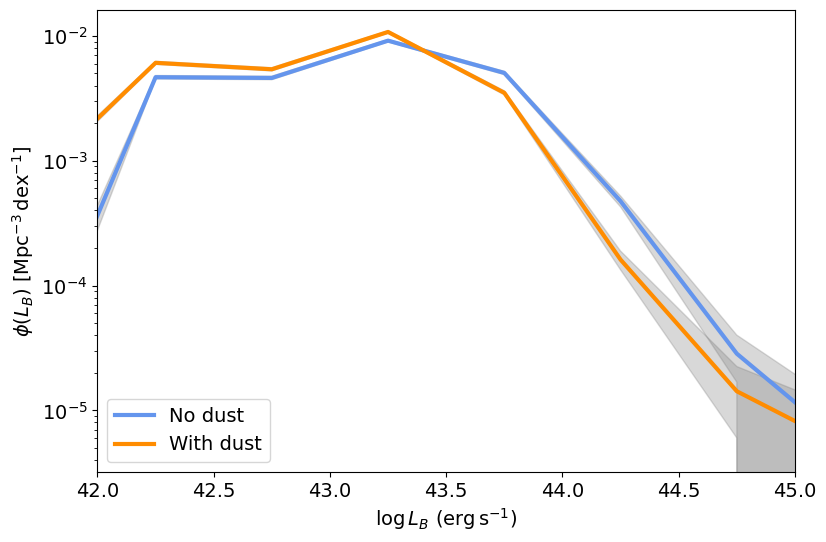

In [37]:
plt.figure(figsize=(9, 6))
plot_lf(bin_centers, phi, sigma_phi, plot_label='No dust', line_color='cornflowerblue')
plot_lf(bin_centers2, phi2, sigma_phi2, plot_label='With dust', line_color='darkorange')

plt.yscale('log')
plt.xlabel(r'$\log L_B\ (\mathrm{erg\,s^{-1}})$')
plt.ylabel(r'$\phi(L_B)\ [\mathrm{Mpc^{-3}\,dex^{-1}}]$')
plt.legend(loc='lower left')

In [17]:
# Get LFs for the different dust LHC parameter combinations

"""
bin_centers0, phi0, sigma_phi0 = get_lf(pipeline_name='pipeline_li08_0_0_0_lhcindex0')
bin_centers1, phi1, sigma_phi1 = get_lf(pipeline_name='pipeline_li08_0_0_0_lhcindex1')
bin_centers2, phi2, sigma_phi2 = get_lf(pipeline_name='pipeline_li08_0_0_0_lhcindex2')
bin_centers3, phi3, sigma_phi3 = get_lf(pipeline_name='pipeline_li08_0_0_0_lhcindex3')
bin_centers4, phi4, sigma_phi4 = get_lf(pipeline_name='pipeline_li08_0_0_0_lhcindex4')
"""

slope0 = get_lf(pipeline_name='pipeline_li08_0_0_0_lhcindex0')
slope1 = get_lf(pipeline_name='pipeline_li08_0_0_0_lhcindex1')
slope2 = get_lf(pipeline_name='pipeline_li08_0_0_0_lhcindex2')
slope3 = get_lf(pipeline_name='pipeline_li08_0_0_0_lhcindex3')
slope4 = get_lf(pipeline_name='pipeline_li08_0_0_0_lhcindex4')

FUV slope: [14.193749 14.193749 14.193749 ... 14.193749 14.193749 14.193749]
Gathered spectra for pipeline_li08_0_0_0_lhcindex0 and (5630, 100000) galaxies
[2.63694753e+22 2.63694753e+22 2.63694753e+22 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
FUV slope: [37.946044 37.946044 37.946044 ... 37.946044 37.946044 37.946044]
Gathered spectra for pipeline_li08_0_0_0_lhcindex1 and (5630, 100000) galaxies
[2.63694753e+22 2.63694753e+22 2.63694753e+22 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
FUV slope: [60.30383 60.30383 60.30383 ... 60.30383 60.30383 60.30383]
Gathered spectra for pipeline_li08_0_0_0_lhcindex2 and (5630, 100000) galaxies
[2.63694753e+22 2.63694753e+22 2.63694753e+22 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
FUV slope: [46.094983 46.094983 46.094983 ... 46.094983 46.094983 46.094983]
Gathered spectra for pipeline_li08_0_0_0_lhcindex3 and (5630, 100000) galaxies
[2.63694753e+22 2.63694753e+22 2.63694753e+22 ... 0.00000000e+00
 0.00000000e+00 0.00000000

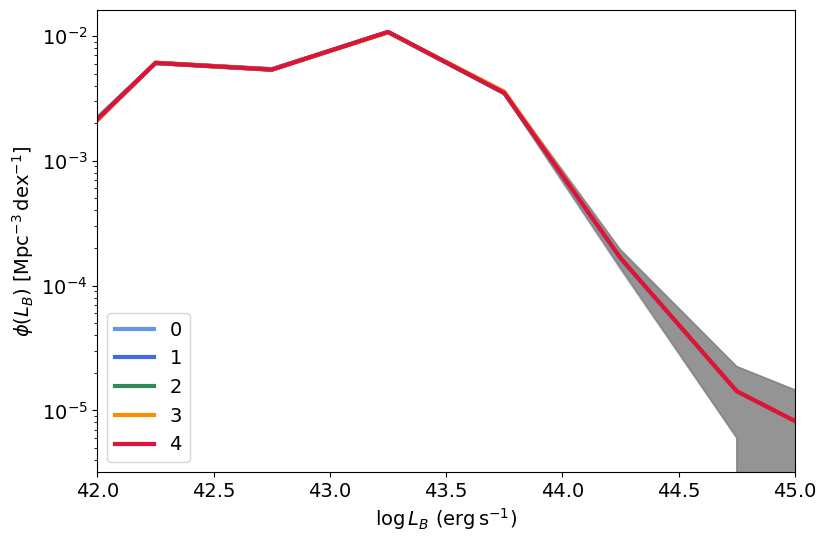

In [11]:
plt.figure(figsize=(9, 6))
plot_lf(bin_centers0, phi0, sigma_phi0, plot_label='0', line_color='cornflowerblue')
plot_lf(bin_centers1, phi1, sigma_phi1, plot_label='1', line_color='royalblue')
plot_lf(bin_centers2, phi2, sigma_phi2, plot_label='2', line_color='seagreen')
plot_lf(bin_centers3, phi3, sigma_phi3, plot_label='3', line_color='darkorange')
plot_lf(bin_centers4, phi4, sigma_phi4, plot_label='4', line_color='crimson')

plt.yscale('log')
plt.xlabel(r'$\log L_B\ (\mathrm{erg\,s^{-1}})$')
plt.ylabel(r'$\phi(L_B)\ [\mathrm{Mpc^{-3}\,dex^{-1}}]$')
plt.legend(loc='lower left')